In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SMSSpamCollection.csv', sep=',', encoding='utf-8', names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.shape

(5572, 2)

In [ ]:
X=list(df['message'])

In [ ]:
y=list(df['label'])

In [ ]:
# y

In [ ]:
y=list(pd.get_dummies(y,drop_first=True)['spam'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length = 512, return_tensors = "tf")
test_encodings = tokenizer(X_test, truncation=True, padding=True,  max_length = 512, return_tensors = "tf")

In [ ]:
# y_train

In [ ]:
y_train_tensor = tf.convert_to_tensor(y_train, dtype = tf.int32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype = tf.int32)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_tensor
)).shuffle(1000).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_tensor
)).batch(16)

In [ ]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=2)

Epoch 1/2
279/279 [==============================] - 139s 407ms/step - loss: 0.0841 - accuracy: 0.9729 - val_loss: 0.0270 - val_accuracy: 0.9937
Epoch 2/2
279/279 [==============================] - 111s 398ms/step - loss: 0.0257 - accuracy: 0.9933 - val_loss: 0.0195 - val_accuracy: 0.9928


In [ ]:
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

70/70 [==============================] - 9s 124ms/step - loss: 0.0195 - accuracy: 0.9928
Test Loss: 0.019493913277983665, Test Accuracy: 0.9928250908851624


In [ ]:
predictions = model.predict(test_dataset)
predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

70/70 [==============================] - 11s 124ms/step


In [ ]:
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[955   0]
 [  8 152]]


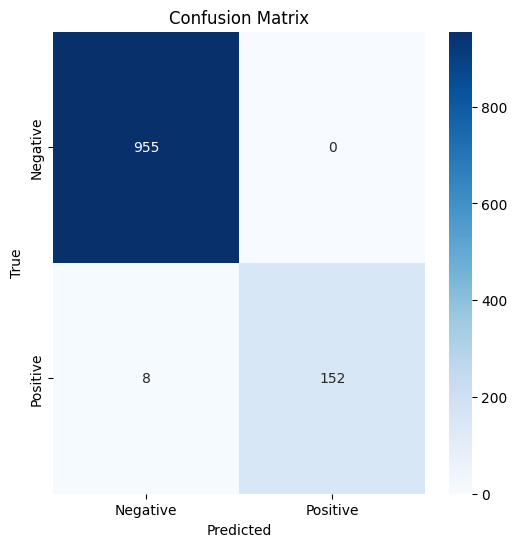

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save_pretrained('./senti_model')